In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
%matplotlib inline

In [128]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# The Ising model in 2D
The Hamiltonian of the Ising model is

$$
\mathcal{H} = -\sum_{\langle ij \rangle} J s_i s_j - H \sum_i s_i
$$

In this exercise, we focus on the case $J=1, H=0$, that is, a ferromagnetic system with no external field. Remember that the sum $\langle ij \rangle$ runs over neighbouring sites only. In our 2D lattice, each site has 4 neighbours. 

<img src="attachment:image.png" width="250"> 


We will work with **periodic boundary conditions**, so that all spins have 4 neighbours. 

<img src="attachment:image.png" width="250"> 


# The Metropolis algorithm
We will build a simple implementation of the **Metropolis** algorithm for the 2D Ising model. 

As a reminder, a single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### Exercice 4.1
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}. 

In [1047]:
def create_initial_config(N=None):
    """
    Create the starting initial configuration.
    
    All elements are {-1, 1} with 50% prob.
    The lattice is a square of size N.
    
    Parameters
    ----------
    N : int
        The system size.

    Returns
    -------
    config : np.array, (N, N)
        A random {-1, 1} array of size (N, N).
    """
    config = np.random.choice([-1,1],size=(N,N))
    return config

Let us create an initail configuration with our `create_inital_config_function`. A system size of $N=100$ will be enough.

In [1050]:
config = create_initial_config(N=100)

To plot our system we can use `plt.imshow()`, as follows:

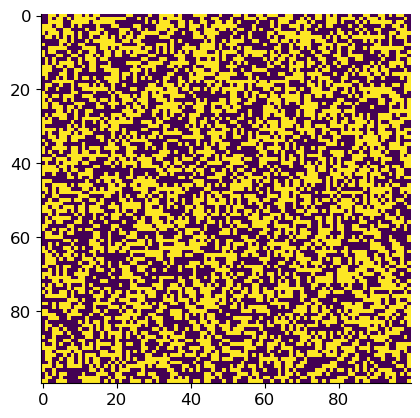

In [1055]:
plt.imshow(config)
plt.show()

### Exercise 4.2
We will write our Metropolis update function. Given a site $(i, j)$, what is the change in energy $\Delta E$ that flipping $S(i, j)$ entails?
Recall that only 4 spins are connected to $(i, j)$, so you don't need to compute the energy of the whole system.

DE=2 S_i,j(S_i+1,j +S_i-1,j +S_i,j-1 + Si_j+1)

### Exercise 4.3
Write a function called `metropolis_single_update()`.  
The **input** should be:

+ *config*, a lattice configuration as an (N, N) array.
+ *T*, the temperatue.

There is no need to return anything since in python, functions can modify its input, so we will be updating config *inplace*. But it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, we will use **periodic boundary conditions** (in python, the modulo operator is `%`).

In [1060]:
def metropolis_single_update(config=None, T=None):
    '''
    Do a single Monte Carlo update using Metropolis algorithm.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The current configuration.
    T : float
        The temperature.

    '''
    # make sure config is square
    N, M = config.shape #salva numero di righe in N e colonne in M
    assert N==M, "matrice non quadrata"
    
    # choose random site
    i = np.random.randint(0,N)
    j = np.random.randint(0,N)
    s =  config[i, j]
        #DE=2 S_i,j(S_i+1,j +S_i-1,j +S_i,j-1 + Si_j+1)
    # compute energy cost of flip
    # DeltaE is the possible energy cost
    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    DeltaE =2*s*(config[(i+1)%N,j]+config[(i-1)%N,j]+config[i,(j-1)%N]+config[i,(j-1)%N])
    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1 
    if DeltaE < 0:
        # flip the sping
        s *= -1
        # set effective DeltaE to DeltaE 
        effDeltaE = DeltaE
        
    # case DeltaE >= 0
    else:
        # flip the spin with certain probability
        #considero costante di boltzmann=1 e quindi beta=1/T
        if np.random.uniform() < np.exp(-DeltaE/T):  
            # flip the sping
            s *= -1
            # set effective Delta E 
            effDeltaE = DeltaE
        
    # update configuration
    # notice there is no need to return the whole configuration, the function
    # will modify config _in_place_
    config[i, j] = s
    
    # but it is clever to return the effective DeltaE, since we have already computed it
    # notice that if we didn't flip the spin, the change in energy is 0
    return effDeltaE

## Visualizing the simulation on real time
To see if our Metropolis algorithm works, you might want to simulate systems at different temperatures, and observe how the configuration evolves trought time. To do this you need the `display` module. Below you will find an example of how to use it.

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
(with $k_B=1$). Try executing the cell below at different values of the temperature, for different system size. 

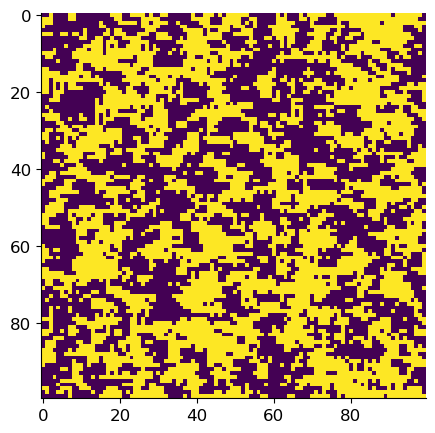

In [1063]:
T_c = 2/np.log(1+np.sqrt(2))

# create initial random configuration
config = create_initial_config(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(6,5))
# draw the initial configuration,
# naming the plot "im".
im = ax.imshow(config)

for t in range(100000):
    # update the system
    DeltaE = metropolis_single_update(config, T=T_c)
    # replot every 1000 MC updates
    if t%1000==0:
        # update the data of the plot (not the whole figure!)
        im.set_data(config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

### Exercice 4.4
Write a function that computes the energy of a configuration, and another that tracks its evolution over time.

In [1066]:
def get_energy(config):
    """
    Compute the energy of a configuration.
    
    The energy is defined as $E = -sum_{(a, b)} S_a S_b$,    
    where the sum runs over pairs of adjacent spins.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The system configuration.
        
        
    Returns
    -------
    E : float
        The energy of the configuration.
    """
    N = len(config)
    # list of pairs of adjacent sites as four-element tuples:
    # (i1, j1, i2, j2) represents two adjacent sites located
    # at (i1, j1) and (i2, j2)
    horizontal_edges = [(i, j, i, (j+1)%N) for i in range(N) for j in range(N) ]
    vertical_edges = [(i, j, (i+1)%N, j) for i in range(N) for j in range(N) ]
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges #lista con dentro tutte le coppie di siti adiacenti riga 1 spin colonna 2 spin
    E = 0  #servono solo i primi vicini, faccio quelli orizz poi quelli verticali
    for i1, j1, i2, j2 in edges:#li molitplico tra loro e sottraggo volta x volta
        E -= config[i1,j1]*config[i2,j2]
    
    return E

In [1068]:
def get_energy_evolution(N=20, T=T_c, n_updates=50000):
    """
    Compute the energy evolution of a 2D Ising instance.
    
    Parameters
    ----------
    N : int
        The system size.
    T : float
        The temperature.
    n_updates : int
        Number of Metropolis updates.
        
    Returns
    -------
    Es : np.array, (n_updates, )
    """
    config = create_initial_config(N)

    Es = np.zeros(n_updates)

    for i in range( n_updates ):
        Es[i] = get_energy(config)
        metropolis_single_update(config,T)
    
    return Es

### Exercise 4.5
Compute the energy of your system during a long simulation, and plot it as a function of time. **Tip** Use logarithmic x-axis!

In [1071]:
energy_evolution =  get_energy_evolution(N=20, T=T_c, n_updates=50000)

In [1072]:
energy_evolution2 =  get_energy_evolution(N=20, T=T_c*1/20, n_updates=50000)

In [1073]:
energy_evolution3 =  get_energy_evolution(N=20, T=20*T_c, n_updates=50000)

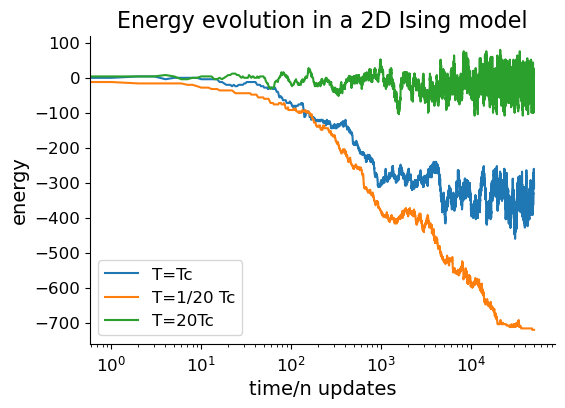

In [1227]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_title("Energy evolution in a 2D Ising model")

ax.semilogx(energy_evolution, label="T=Tc")
ax.semilogx(energy_evolution2, label="T=1/20 Tc")
ax.semilogx(energy_evolution3, label="T=20Tc")
ax.set_xlabel("time/n updates")
ax.set_ylabel("energy")
ax.legend()
plt.show()

### Exercise 4.6
Can you distinguish two qualitatively different periods? What do they correspond to?

In the first period the energy tends to drop rapidly, because the system, which is initially prepared in a random configuration, tries to reach the thermodynamical equilibrium by approaching the point of minimum mean energy. During the second period, the system is equilibrated and it's possible to see statistical fluctuations of energy, which are broader from the critical temperature onwards.

# Efficient Metropolis
Our implementation of the Ising model was not very efficient. To do this exercice, we will use part of the code from Sethna's book, which is much more efficient and can be found here:

[Sethan's book computer exercices](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/Ising/Ising.html)

To import code from an external file, we need to add its directory to the PATH



In [1081]:
import sys
sys.path.append("../code/")
from ising_sethna import IsingModel

Their implementation is based on a `Class`, which means we need to instantiate the model. For instance:

In [1084]:
# create an instance of IsingModel
ising = IsingModel(N=100)

In [1086]:
# the state of the system is stored in .lattice
ising.lattice

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

In [1088]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.imshow(ising.lattice)

Notice that this implementation uses 0, 1 spins instead of -1, 1 as we are used to! To run the simulation, we call the `.SweepMetropolis()` method. If you go to the source file at `SethnasBookCode/Ising.py`, you can inspect all the code. You will notice that all `.Sweep...()` methods perform $N^2$ updates per time-step. This is useful because time-scales become independent of system size.

In [1091]:
ising.SweepMetropolis(nTimes=100) #gira n^2 volte eliminando la dipendenza da n^2

In [1092]:
plt.imshow(ising.lattice)

The cell bellow will display 3 systems side-by-side, running at different temperatures. All parameters are set at the top. Try changing some values and see what happens.

In [1094]:
#################
# set parameters
system_size = 100
H = 0.0
T_below = 1.5
T_critical = 2.269185314213022
T_above = 3.5
n_sweeps = 100
###############

# create three instances of IsingModel
ising_below = IsingModel(N=system_size, T=T_below, H=H)
ising_critical = IsingModel(N=system_size, T=T_critical, H=H)
ising_above = IsingModel(N=system_size, T=T_above, H=H)

# give them names
isings = [ising_below, ising_critical, ising_above]
labels = ["below $T_c$", "at $T_c$", "above $T_c$"]

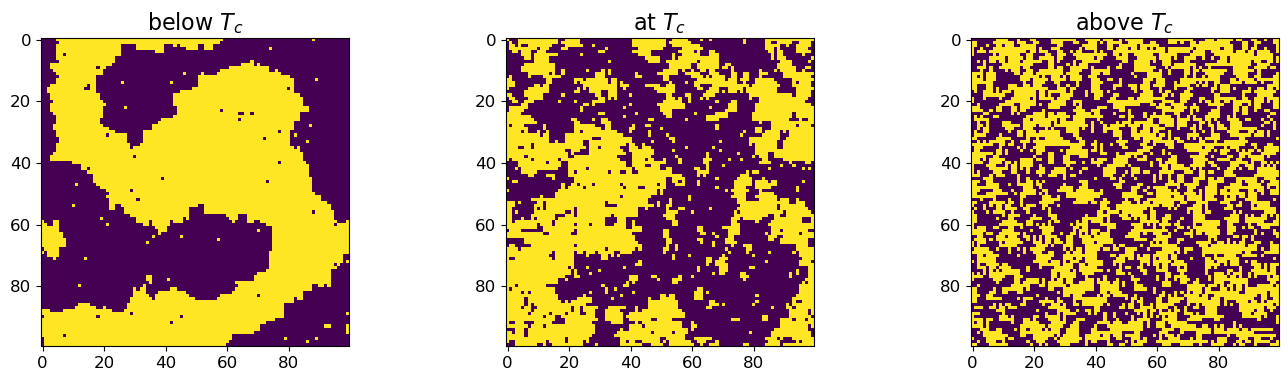

In [1098]:
fig, axx = plt.subplots(1, 3, figsize=(17,4))
heatmap = {}
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

for _ in range(n_sweeps):
    for ax, ising, label in zip(axx, isings, labels):
        ising.SweepMetropolis(nTimes=1)
        heatmap[label].set_data(ising.lattice)
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Exercice 4.7
How much faster is Sethna's implementation with respect to ours? Use the cell magic `%%timeit` to measure how long a command takes to execute.

To do a fair comparison, remember to take into account what "one update" means for each case.

In [1100]:
%%timeit
# your Ising implementation running for some number of updates
config = create_initial_config(N=100)
for t in range(1000000):
    DeltaE = metropolis_single_update(config, T=T_c)

7.65 s ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1116]:
%%timeit
# Sethan's implementation running for some **equivalent** number of updates
ising= IsingModel(N=100, T=T_c)
deltae =ising.SweepMetropolis(nTimes=100)

2.01 s ± 43.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


sethna's code is around 70% faster than mine

## Magnetization
We will now compute the magnetization $M$ as a function of the temperature $T$. To speed up simulations even more, we will use the Wolff algorithm, which Sethna's code already implements in the `.SweepWolff()` method.

### Exercise 4.8
For a system of size $N=100$, approximately how many sweeps of the Wolff algorithm are necessary in practice to be in equilibrium? Try starting with smaller values of $N$, and increase gradually. 

In [1279]:
def equilibrium_threshold(T=None, T_c=T_c):
#soglia per calcolare equilibrio
#mi aspetto delle fluttuazioni di energia più basse per temperature inferiori a quella critica,
    #più alte per temperature superiori e ancora maggiori a T=T_c
    if(T<T_c):
        threshold= T*10
    elif(T>T_c):
        threshold=T*15
    else:
        threshold=T*25
    return threshold


210.8330144925125
Equilibrio ''raggiunto'' a sweep numero 34, soglia di equilibrio:37.5
101.64723311531898
Equilibrio ''raggiunto'' a sweep numero 231, soglia di equilibrio:37.5


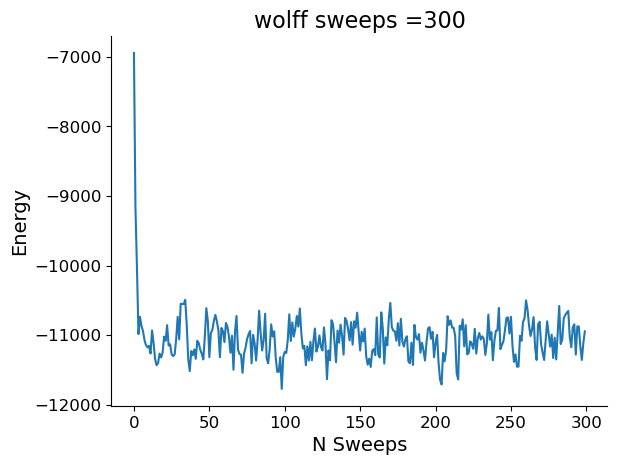

In [1289]:
# set system size, temperature
N=100
T=2.5

#creo un'istanza del modello di Ising
ising = IsingModel(N, T)

#converto la configurazione degli spin da 0/1 a -1/+1
config = 2 * ising.lattice - 1
# run some Wolff sweeps, check if equilibrium
# Lista per salvare il valore della magnetizzazione per ogni sweep
energies = []

# Esegui vari sweep per osservare l'equilibrio
num_sweeps = 300  # Numero di sweep per verificare l'equilibrio

for sweep in range(num_sweeps):
    ising.SweepWolff()  # Esegui uno sweep dell'algoritmo Wolff
    config = 2 * ising.lattice - 1
    energies.append(get_energy(config))
    if sweep > 10:

        if np.std(energies[-4:])<equilibrium_threshold(T) :
            print(np.std(energies[-5:]))
            print(f"Equilibrio ''raggiunto'' a sweep numero {sweep}, soglia di equilibrio:{equilibrium_threshold(T)}")

plt.plot(range(num_sweeps), energies)
plt.xlabel('N Sweeps')
plt.ylabel('Energy')
plt.title(f'wolff sweeps ={num_sweeps}')
plt.show()
      


roughly around 50 sweeps

### Exercise 4.9
Write a function that computes the magnetization of a 2D Ising system after certain equilibration period.

In [1293]:
def calculate_magnetization(system_size=None, temperature=None, equilibration_time=None):
    """
    Calculate the magnetization of a 2D Ising model.
    
    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of Wolff sweeps before measuring M.
         if np.std(energies[-10:]) < 0.01 and abs(energies[-1] - energies[-2]) < 0.01:
            print(f"Equilibrio raggiunto a sweep numero {sweep}")
    """
    # instantiate model
    if system_size is None:
        system_size=100 #istanzio di default N=100, T=2,5 , eq_time=50
    if temperature is None:
        temperature=2.5
    if equilibration_time is None:
        equilibration_time=50
    
    ising=IsingModel(N=system_size,T=temperature) #creo il sistema
    
    # equilibrate
    for _ in range(equilibration_time):
        ising.SweepWolff() #porto il sistema all'equilibrio
        
    # compute magnetization
    config=2*ising.lattice-1
    m=np.sum(config)/(system_size**2)
    return m


### Exercise 4.10
+ Compute the magnetization for a system of size $N=64$, for diverent values of $T\in[1.5, 3.5]$.
+ Remember to choose wisely the equilibration time!
+ Plot $|M|$ as a function of $T$, and mark the critical temperature in your plot using the `plt.axvline()` function.

In [1296]:
# define range of temperatures
temperatures = np.linspace(1.5, 3.5, num=150)
# system size
system_size = 64
# equilibration time
equilibration_time = 50

# loop over temperatures, compute magnetizations
magnetizations = []
for temperature in temperatures:
    magnetization = calculate_magnetization(system_size, temperature, equilibration_time)
    magnetizations.append(magnetization)

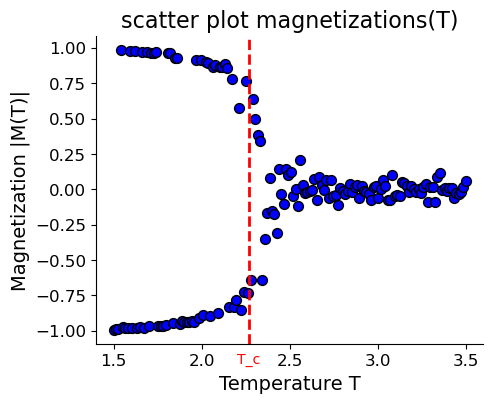

In [1297]:
# define critical temperature
T_c = 2/np.log(1+np.sqrt(2))

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(
    temperatures,magnetizations,
    # style keywords
    edgecolors="black", color="blue", s=50
)
ax.axvline( #aggiunge una linea verticale al grafico
    # style keywords
    T_c,
    c="red", lw=2, ls="--"
)
ax.text(T_c, -1.25, "T_c", color="red", fontsize=10, ha="center", va="bottom")#marca il punto sull'asse x

ax.set_title("scatter plot magnetizations(T)")
ax.set_xlabel("Temperature T")
ax.set_ylabel("Magnetization |M(T)|")
plt.show()

## Susceptibility and Specific Heat


In this exercice, we will compute the susceptibility $\chi$ and the specific heat $C$. Using formula (6.13) in the book, we have that
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle.
$$
Remember that this is only valid in **equilibrium**, which means that we can only measure energy fluctuations **after a transient** equilibration time.

### Exercise 4.11
Find a convenient formula to measure the susceptibility $\chi$ in a simulation.

1/(Kb*T) * variance(M) with Kb=1


### Exercise 4.12
Write a function that computes the energy of an Ising configuration.

As usually, you can use the **template** below if it helps you, or if you prefer you can also write **your own function** from scratch.

In [1167]:
def compute_energy(ising):
    """Compute the energy of an ising object."""

    config=ising.lattice *2 -1
    N = len(config)
    horizontal_edges = [(i, j, i, (j+1)%N) for i in range(N) for j in range(N) ]
    vertical_edges = [(i, j, (i+1)%N, j) for i in range(N) for j in range(N) ]
    edges = horizontal_edges + vertical_edges 
    E = 0  
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]
    
    return E / N**2

### Exercise 4.13
Write a function that computes the susceptibility and the specific heat of a 2D Ising system. You might use the Wolff algorithm to speed up your simulations.

In [1170]:
def calculate_susceptibility_specific_heat(system_size=None, temperature=None, equilibration_time=None, n_samples=None):
    """
    Simulate a 2D Ising model and measure its
    specific heat and susceptibility at equilibrium.
    
    Parameters
    ----------
    system_size : int
        The lattice side length.
    temperature :  float.
        The simulation temeperature.
    equilibration_time : int
        A transient period to allow for thermalization.
    n_samples : int
        The number of samples taken to compute fluctuations.

    """
    if system_size is None:
        system_size=100 
    if temperature is None:
        temperature=2.5
    if equilibration_time is None:
        equilibration_time=40
    if n_samples is None:
        n_samples= 50

    
    # initiate model
    ising=IsingModel(system_size, temperature)
    
    # thermalize
    for _ in range(equilibration_time):
        ising.SweepWolff()
    
    # create empty lists for magnetizations, energies, and their squares
    ms = []
    m2s = []
    es = []
    e2s = []
    
    # loop over n_samples 
    for _ in range(n_samples):
        # change from 0,1 to -1,1 notation
        config= 2* ising.lattice -1
        # get magnetization
        m=np.sum(config)/(system_size**2)
        ms.append(m)
        m2s.append(m**2)
        
        # get energy
        e=compute_energy(ising)
        es.append(e)
        e2s.append(e**2)
        
        # update system
        ising.SweepWolff()
    
    # compute susceptibility and specific heat
    susceptibility = 1/temperature * (np.mean(m2s)-(np.mean(ms)**2))

    specific_heat= 1/(temperature**2) *(np.mean(e2s)-(np.mean(es)**2))
    
    return susceptibility, specific_heat



### Exercise 4.14
+ Compute $C$ and $\chi$ at different temperatures, for a small system of size $N<50$. You will need to find what are the right equilibration times. A good range of temperatures is $T \in [1.5, 3.5]$.
+ Make two plots, showing $\chi$ and $C$ as a function of $T$. Mark the critical temperature $T_c$ with a vertical line using `ax.axvline(...)`.

In [1173]:
# define range of temperatures: 50 points from 1.5 to 4.
temperatures = np.linspace(1.5, 4, num=50)

# system size
system_size = 40

# equilibration time
equilibration_time = 50

# n_samples
n_samples = 100
#liste python (array dinamici) per chi e c
chi=[]
c=[]

# loop over temperatures, compute susceptibility and specific_heat
for T in temperatures:
    
    chi_value, c_value= calculate_susceptibility_specific_heat(system_size, T, equilibration_time, n_samples)
    
    chi.append(chi_value)
    c.append(c_value)


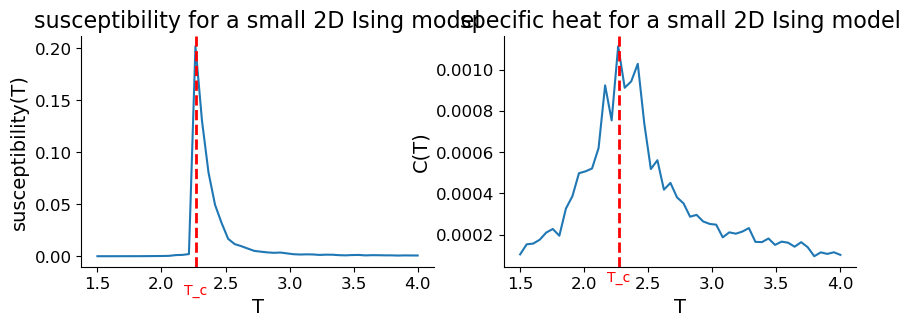

In [1175]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax=ax1

ax.plot(temperatures, chi)
ax.axvline(T_c, c="red", lw=2, ls="--")
ax.text(T_c, -0.04, "T_c", color="red", fontsize=10, ha="center", va="bottom")
ax.set_ylabel("susceptibility(T)")
ax.set_xlabel("T")
ax.set_title("susceptibility for a small 2D Ising model")

ax=ax2

ax.plot(temperatures, c)
ax.axvline(T_c, c="red", lw=2, ls="--")
ax.text(T_c, -ax.get_ylim()[0], "T_c", color="red", fontsize=10, ha="center", va="bottom")


ax.set_ylabel("C(T)")
ax.set_xlabel("T")
ax.set_title("specific heat for a small 2D Ising model")
plt.show()

### Exercise 4.15
Discuss whether or not your results proof the existence of a phase transition.

These results proove the existence of a phase transition because of a divergence of both χ and c around the critical temperatures, where the statistical fluctuations are maximum. In the specific heat plot, the peak at the critical temperature indicates the point where energy fluctuatons are at their highest, suggesting a transition between an ordered state (low temperature) to a disordered one (high temperature). The susceptivity behaves in the same way: at the critical temperature, the system becomes highly senstitive to magnetic fields, marking a transition from a saturated magnetic state (low temperatures and more correlations between spins) to an uncorrelated one (high temperature mean uncorrelated spins because thermal disorder dominates)

# Finding clusters
Given an Ising configuration, we define a cluster of spins as a set of neighbouring spins of the same sign surrounded by spins of the opposite sign.

<img src="attachment:image.png" width="600">

### Exercise 4.16
The formal definition of cluster is very clear, but in practice, how do you find (*efficiently* if possible) all clusters for a given configuration? We need to assign a **unique cluster label** to each spin. The cluster label could be anything (a color, a letter, a number...), it just needs to be the same for all spins that belong to the same cluster. For simplicity, we will use integers.

Think about an algorithm that assigns unique cluster labels to spins. Explain your algorithm in simple words / steps / pseudocode.

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!

-take one point on the grid
-if it isn't labelled yet, label it whith a new label
-check if in the 4 neighbours there is a spin in the same state, if so, label it whith the same label used at the previous point and move to its cell, then take away from the grid the previous labelled point
-repeat until there are no more equivalent neighbours. When this appens, move to the next cell and set a new label
-repeat until there are no points left on the grid


### Exercise 4.17
Write a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label.

<img src="attachment:image.png" width="600">

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!


In [1184]:


def get_labels(config):
    N = config.shape[0]
    labels = np.zeros((N, N), dtype=int)
    k = 1  # Contatore per i cluster, k=0 indica punto non etichettato

    def check_close_points(i, j, k):
        #funzione per etichettare tutti i vicini con il numero di cluster corrente
        temp = [(i, j)]  #inizializzo una lista con il punto di partenza
        while temp:#sta dentro al ciclo finche la lista è vuota: ogni volta che trovo un nuovo punto appartenente al cluster, tolgo quello corrente e passo a quello successivo
            x, y = temp.pop()  #toglie dalla lista il punto corrente
            if labels[x, y] == 0:  # Se la cella non è ancora etichettata, la etichetto
                labels[x, y] = k  

                #lista dei vicini (destra, sinistra, sotto, sopra)
                neighbors = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]
                for newx, newy in neighbors:
                    #condizioni al contorno periodiche
                    newx = newx%N
                    newy = newy%N

                    #se il vicino fa parte del cluster ed è ancora non etichettato
                    if config[newx, newy] == config[x, y] and labels[newx, newy] == 0:
                        temp.append((newx, newy))  #lo aggiungo alla lista e riparto da lì facendo un altro giro nel ciclo

#avvio la ricerca di cluster su tutta la griglia
    for i in range(N):
        for j in range(N):
            if labels[i, j] == 0:  #controllo se il punto non è etichettato 
                check_close_points(i, j, k)
                k += 1  #passo al prossimo cluster

    return labels

### Test your function
To help you **test** your function, I have prepared some test data, so that we can all try our algorithms using the same input.

In [1187]:
config_test_0 = np.array([[ 1,  1,  1],
                          [-1, -1,  1],
                          [-1, -1,  1]])

In [1189]:
config_test_1 = np.array([[ 1, -1, -1,  1, -1,  1],
                          [-1, -1, -1,  1, -1,  1],
                          [-1,  1, -1, -1, -1,  1],
                          [-1,  1, -1,  1,  1,  1],
                          [-1,  1, -1, -1,  1, -1],
                          [-1, -1, -1,  1,  1,  1]])

In [1191]:
config_test_2 = np.array([[ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [-1, -1, -1,  1,  1, -1, -1, -1,  1, -1],
                          [ 1, -1,  1, -1, -1, -1,  1,  1, -1,  1],
                          [ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
                          [-1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [ 1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
                          [-1,  1, -1,  1,  1, -1, -1, -1,  1,  1],
                          [-1, -1, -1, -1,  1,  1, -1, -1, -1,  1],
                          [ 1,  1, -1, -1,  1, -1,  1,  1,  1,  1],
                          [ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1]])


Execute the following cell to make sure your function works correctly. The left column will show the test configurations, and the right column will show the clusters your function found, with different clusters colored in different colors

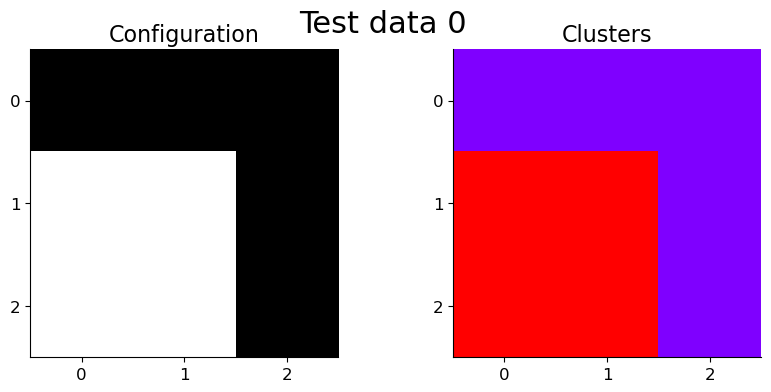

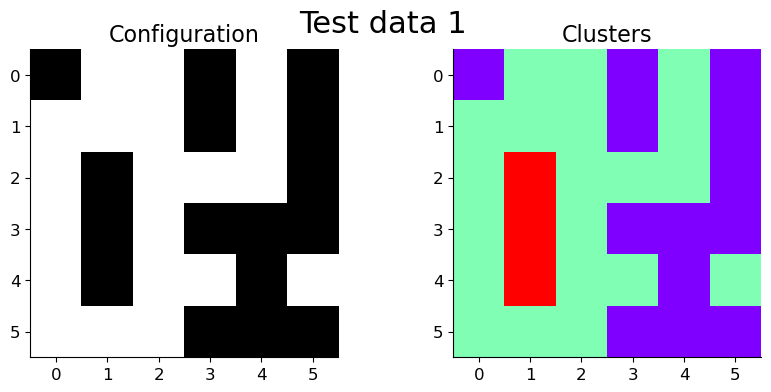

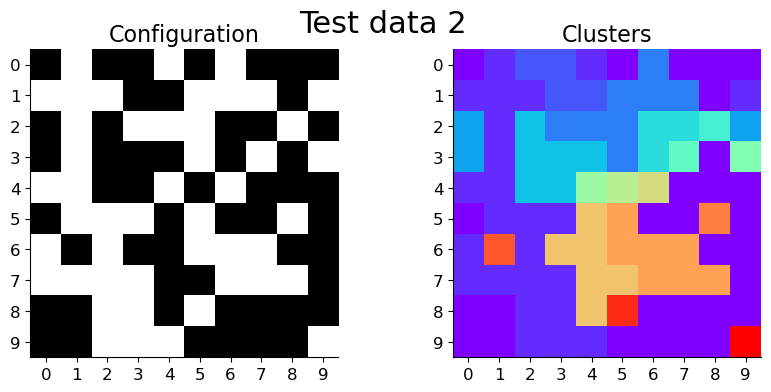

In [1194]:
for i, config in enumerate([config_test_0, config_test_1, config_test_2]):
    labels = get_labels(config)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.set_xticks(range(len(config)))
    ax1.set_yticks(range(len(config)))
    ax2.set_xticks(range(len(config)))
    ax2.set_yticks(range(len(config)))
    ax1.set_title("Configuration")
    ax2.set_title("Clusters")
    ax1.imshow(config, cmap="Greys")
    ax2.imshow(labels, cmap="rainbow")
    
    fig.suptitle(f"Test data {i}", fontsize=22)
    plt.show()

If your function doesn't work, you might want to use this cell to inspect your results

In [1197]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_aspect(1)
sns.heatmap(labels, annot=True, ax=ax, cmap="viridis")

<Axes: >

### Measuring cluster sizes
Use your `get_labels()` function to find clusters in a large Ising model, say $N=500$. You can use your own Ising implementation. If you use Sethna's code, remember that he uses $s \in \{0, 1\}$ spins!

In [1200]:
#creo il sistema
N=500
eq_sweeps=50
ising=IsingModel(N,T=T_c)

#porto all'equilibrio
for _ in range(eq_sweeps):
   ising.SweepWolff()
#trovo i cluster
config= 2* ising.lattice -1
labels = get_labels(config)

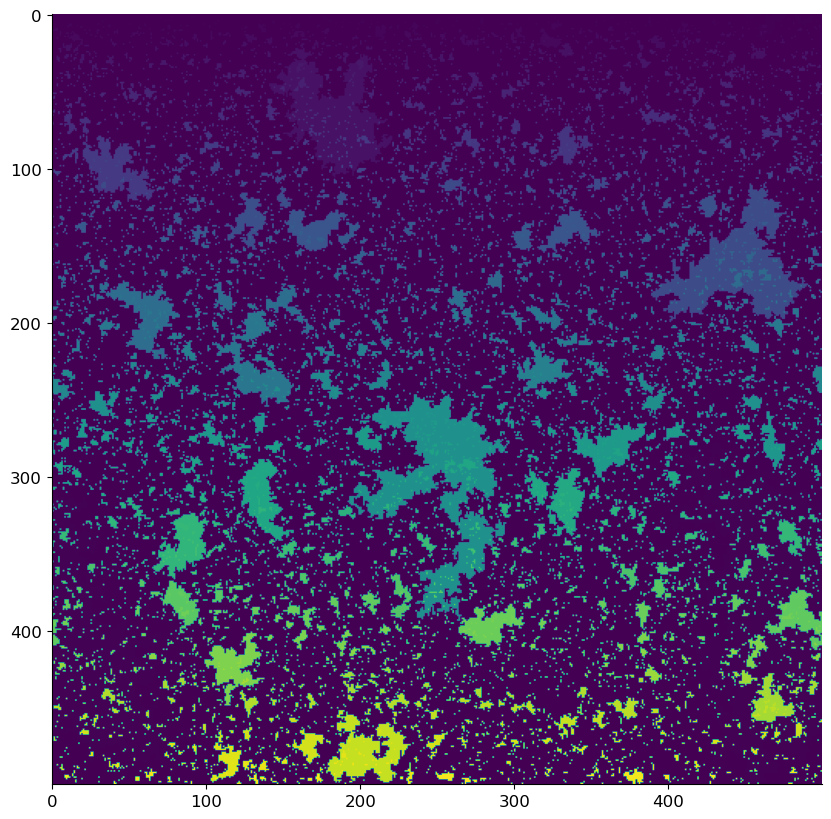

In [1204]:

plt.figure(figsize=(10, 10))
plt.imshow(labels) 
plt.show()

### Exercise 4.18
Find an efficient way to measure cluster sizes. Remind that all you care about is the distribution of cluster sizes, their location does not matter. You might want to use the `.reshape()` method of a numpy array, and the `Counter` class from the `collections` package.

In [1208]:
from collections import Counter

In [1210]:
def get_sizes(labels):
    
    N=labels.shape[0]
    
    labels_array=labels.reshape(N**2)#trasformo la matrice in un vettore riga
    
    sizes=Counter(labels_array)#counters conta, per ogni elemento, quante volte compare nell'array
    
    return sizes #sizes è un oggetto di tipo counter

### Exercise 4.19
For $T >> T_c$, spins are essentially uncorrelated. What is the distribution of cluster sizes you expect to find in this case? **Hint** Think about the 1D case assuming totally uncorrelated spins.

Since the spins are uncorrelated, it will be less likely that a cluster is formed. Therefore in this case i expect to find a distribution of more and smaller clusters 



### Exercice 4.20
Do a simulation at very high temperature and measure the cluster size distribution. Plot your results in log-log scale. Do your results agree with your previous answer?

in log-log scale, the cluster size distribution follows a linear and decreasing behaviour. This suggests that the distribution of cluster sizes follows an exponentially decreasing law, which confirms the fact that in this case there are significantly more smaller clusters ,while the big ones are very rare compared to them

In [1218]:
N=500
T=5000
#equilibrio
eq_sweeps=50
ising=IsingModel(N,T)
for _ in range(eq_sweeps):
    ising.SweepWolff()


config = 2* ising.lattice -1
labels = get_labels(config)
sizes = get_sizes(labels)



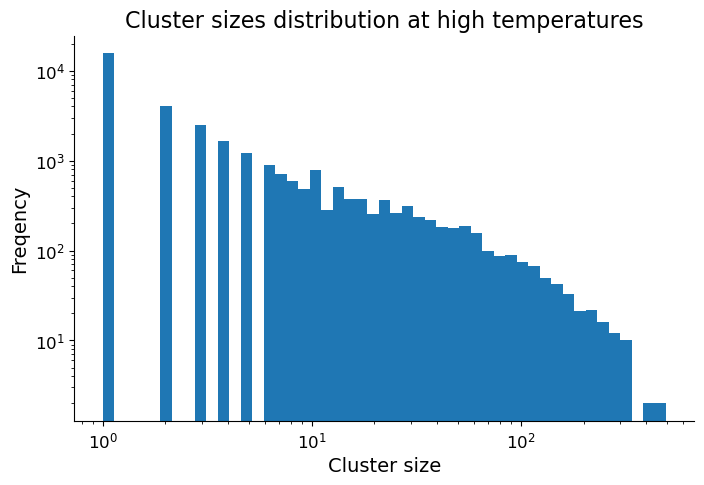

In [1219]:
sizes_values=list(sizes.values()) #list(sizes.values()) prende solo i valori assunti (togliendo i nomi) dalle variabili di un Counter e li mette in sizes_values

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.hist(sizes_values, bins=np.geomspace(np.min(sizes_values), np.max(sizes_values)))

ax.set_xlabel("Cluster size")
ax.set_xscale("log")
ax.set_ylabel("Freqency")
ax.set_yscale("log")

ax.set_title("Cluster sizes distribution at high temperatures")
plt.show()


### Exercise 4.21

At $T_c$, the distribution of cluster sizes is known to be a power law with exponent close to $\alpha \simeq 2$.

$$
P(s) \propto s^{-\alpha}
$$

Do a simulation at $T=T_c$ and compare the resulting cluster size distribution with that obtained at $T>>T_c$.

In [1221]:
# do simulation
N=500
eq_sweeps=50

critical_ising=IsingModel(N,T_c)

for _ in range(eq_sweeps):
    critical_ising.SweepWolff()
critical_config = 2* critical_ising.lattice -1
critical_labels = get_labels(critical_config)
critical_sizes = get_sizes(critical_labels)


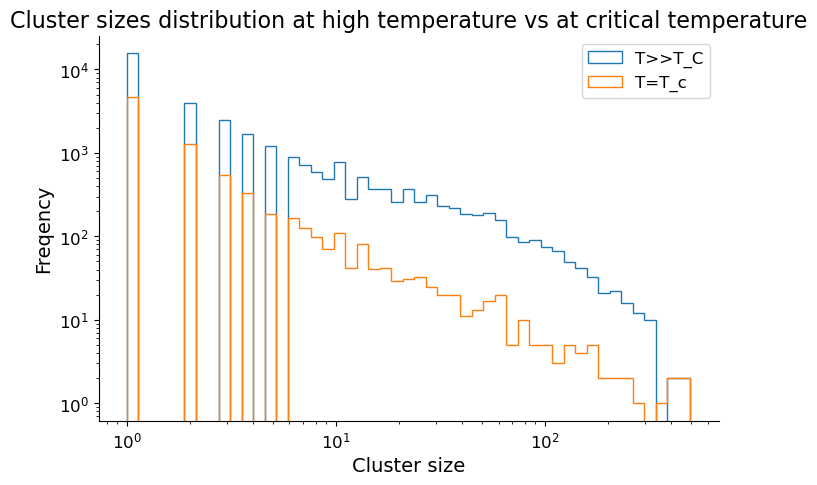

In [1222]:

sizes_values=list(sizes.values()) 
critical_sizes_values=list(critical_sizes.values())

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.hist(sizes_values, bins=np.geomspace(np.min(sizes_values), np.max(sizes_values)), histtype="step", label="T>>T_C")
ax.hist(critical_sizes_values, bins=np.geomspace(np.min(sizes_values), np.max(sizes_values)), histtype="step", label="T=T_c")
ax.set_xlabel("Cluster size")
ax.set_xscale("log")
ax.set_ylabel("Freqency")
ax.set_yscale("log")
ax.set_title("Cluster sizes distribution at high temperature vs at critical temperature")
ax.legend()
plt.show()